In [1]:
from mnist import MNIST
import numpy as np
from matplotlib import pyplot as plt
import types
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
def load_data():
    mnist_data = MNIST('./')
    train_img, train_label = mnist_data.load_training()
    test_img, test_label = mnist_data.load_testing()
    return np.array(train_img), np.array(train_label, dtype="uint8"), np.array(test_img), np.array(test_label, dtype="uint8")

# Execute function
train_img, train_label, test_img, test_label = load_data()

In [3]:
def vectorize_label(label, num_class):
    return np.eye(num_class)[label.reshape(-1)]

# Execute function
NUM_CLASS = 10
train_label = vectorize_label(train_label, NUM_CLASS)
test_label = vectorize_label(test_label, NUM_CLASS)

In [4]:
def initialize_weight(width, height):
    range_ = 0.12
    return np.random.rand(width,height) * range_ * 2 - range_

In [5]:
def derivative_linear(X):
    return np.ones_like(X)

In [6]:
def relu(z):
    return z * (z > 0) * 1

In [7]:
def derivative_relu(X):
    return (X>0) * 1

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
def derivative_sigmoid(X):
    return X * (1 - X)

In [10]:
def softmax(z):
    activate = np.exp(z - z.max(axis=0))
    return activate / activate.sum(axis=0)

In [11]:
def cost_softmax(activation, ground_truth, all_W=0, lambdaa=0):
    m = np.size(activation, 1) # Number of example
    regularized_term_cost = 0
    if isinstance(all_W, list):
        for single_W in all_W:
            W_sliced = single_W.copy()
            W_sliced[:,0] = 0 # Zeroes out bias weight
            regularized_term_cost += lambdaa / 2 / m * (W_sliced ** 2).sum();
    cost = (-ground_truth * np.log(activation)).sum() / m + regularized_term_cost;
    return cost

In [12]:
def grad_softmax(activation, ground_truth, W, X, derivative_method=None, lambdaa = 0):
    m = np.size(activation, 1) # Number of example
    W_sliced = W.copy()
    if W_sliced is not 0:
        W_sliced[:,0] = 0 # Zeroes out bias weight

    err = (activation - ground_truth) / m
    regularized_term_grad = lambdaa / m * W_sliced
    grad = err.dot(X.T) + regularized_term_grad
    if isinstance(derivative_method, types.FunctionType):
        err = W.T.dot(err) * derivative_method(X)
    return grad, err

In [13]:
def softmax_classifier(all_W, X, Y, derivative_method=None,lambdaa = 0):
    if isinstance(all_W, list):
        W = all_W[len(all_W) - 1] # Softmax weight
        
        # Forward pass
        activation = softmax(W.dot(X));
        pred = activation
        ground_truth = Y
        
        # Compute cost
        cost = cost_softmax(activation, ground_truth, all_W, lambdaa)
        
        # Compute gradient and error
        grad, err = grad_softmax(activation, ground_truth, W, X, derivative_method, lambdaa)
        return cost, grad, err, pred

In [14]:
def numerical_softmax_check(W, X, Y, lambdaa=0):
    eps = 1e-6
    grad = np.zeros_like(W)
    for i in range(np.size(W,0)):
        for j in range(np.size(W,1)):
            temp = W[i,j]
            W[i,j] = temp + eps
            cost1, grad1, err1, pred1 = softmax_classifier([W],X,Y,lambdaa=lambdaa)
            W[i,j] = temp - eps
            cost2, grad2, err2, pred2 = softmax_classifier([W],X,Y,lambdaa=lambdaa)
            W[i,j] = temp
            grad[i,j] = (cost1 - cost2) / 2 / eps
    return grad

In [15]:
def backprop(err, W, X, derivative_method=None, lambdaa = 0):
    m = np.size(X, 1) # Number of example
    W_sliced = W.copy()
    if W_sliced is not 0:
        W_sliced[:,0] = 0 # Zeroes out bias weight
    regularized_term = lambdaa / m * W_sliced
    err = err[1:,:] # Shed virtual err
    grad = err.dot(X.T) + regularized_term
    if isinstance(derivative_method, types.FunctionType):
        err = W.T.dot(err) * derivative_method(X)
    return grad, err

In [16]:
W = initialize_weight(2,3)
X = initialize_weight(3,3)
ground_truth = np.zeros((2,3))
ground_truth[0,:] = 1
# Check softmax grad function without regularized term
grad = numerical_softmax_check(W,X,ground_truth)
cost2, grad2, err2, pred2 = softmax_classifier([W],X,ground_truth)
# Check softmax grad function with regularized term = 1
grad3 = numerical_softmax_check(W,X,ground_truth, lambdaa=1)
cost4, grad4, err4, pred4 = softmax_classifier([W],X,ground_truth, lambdaa=1)
print("Relative diffrence without regularization\n",np.linalg.norm(grad - grad2) / np.linalg.norm(grad + grad2))
print("Relative difference with regularization = 1\n",np.linalg.norm(grad3 - grad4) / np.linalg.norm(grad3 + grad4))

Relative diffrence without regularization
 2.4535659149832868e-09
Relative difference with regularization = 1
 1.2332096280000679e-09


In [17]:
def neural_network(all_W, train_data, train_label, lambdaa=0):
    m = np.size(train_data, 1) # Number of training example
    list_activation = []
    list_grad = []
    
    row_of_one = np.ones((1,m))
    activation = train_data
    activation = np.vstack((row_of_one, activation))
    list_activation.append(activation)
    
    # Forward pass
    for i in range(len(all_W) - 1):
        Z = all_W[i].dot(activation)
        activation = sigmoid(Z)
        activation = np.vstack((row_of_one, activation))
        list_activation.append(activation)
    cost, grad, err, pred = softmax_classifier(all_W, activation, train_label, derivative_sigmoid, lambdaa=lambdaa)
    list_activation.append(pred)
    list_grad.append(grad)
    
    # Backward pass
    for i in range(len(all_W) - 2, -1, -1):
        grad, err = backprop(err, all_W[i], list_activation[i], derivative_sigmoid, lambdaa=lambdaa)
        list_grad.append(grad)
    
    return list_grad, list_activation, cost;

In [18]:
def numerical_grad_check(all_W, X, Y, lambdaa=0):
    eps = 1e-6
    list_grad = []
    for k in range(len(all_W)-1,-1,-1):
        W = all_W[k]
        grad = np.zeros_like(W)
        for i in range(np.size(W,0)):
            for j in range(np.size(W,1)):
                temp = W[i,j]
                W[i,j] = temp + eps
                list_grad, list_activation, cost = neural_network(all_W, data, label, lambdaa)
                W[i,j] = temp - eps
                list_grad2, list_activation2, cost2 = neural_network(all_W, data, label, lambdaa)
                grad[i,j] = (cost - cost2) / 2 / eps
                W[i,j] = temp
        list_grad.append(grad)
    return list_grad

In [19]:
# Check gradient backprop
data = np.random.rand(784, 10)
label = np.zeros((10, 10))
label[0,:] = 1
W1 = initialize_weight(25, 785)
W2 = initialize_weight(15,26)
W3 = initialize_weight(10,16)
all_W = [W1, W2, W3]
lambdaa = 1
#77777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777777
list_grad, list_activation, cost = neural_network(all_W, data, label, lambdaa)
list_grad2 = numerical_grad_check(all_W, data, label, lambdaa)

print("Relative diffrence first layer\n", np.linalg.norm(list_grad[2] - list_grad2[2]) / np.linalg.norm(list_grad[2] + list_grad2[2]))
print("Relative diffrence second layer\n", np.linalg.norm(list_grad[1] - list_grad2[1]) / np.linalg.norm(list_grad[1] + list_grad2[1]))
print("Relative diffrence third layer\n", np.linalg.norm(list_grad[0] - list_grad2[0]) / np.linalg.norm(list_grad[0] + list_grad2[0]))

Relative diffrence first layer
 5.149089190555302e-08
Relative diffrence second layer
 1.4010999997667659e-08
Relative diffrence third layer
 1.4303950742506004e-09


In [20]:
def training(all_W, train_data, train_label, batch_size=30, learning_rate=0.001, num_loop=50, lambdaa=0, shuffle=0):
    m = np.size(train_data, 1)
    average_cost = 0
    times = 0
    for i in range(num_loop):
        # Shuffle data randomly
        if shuffle is not 0:
            print("Shuffle")
            permutation = np.random.permutation(m)
            train_data = train_data[:,permutation]
            train_label = train_label[:, permutation]
            print("Done")
        
        for j in range(0,m,batch_size):
            list_gradient, list_activation, cost = neural_network(all_W, train_data[:,j:j+batch_size], train_label[:,j:j+batch_size], lambdaa)
            list_gradient.reverse()
            for j in range(len(all_W)): # Update all W
                all_W[j] -= learning_rate * list_gradient[j]
            average_cost += cost
            times += 1
        print("Iterate ", i+1, " loss: ", average_cost / times)
        average_cost = 0
        times = 0

In [21]:
train_input = (train_img/255).T # Train data shape: 784 x 60000
train_truth = train_label.T # Train label shape: 10 x 60000
# First layer logistic - shape: 25 x 785
W1 = initialize_weight(25, 785)
# Second layer logistic - shape: 15 x 26
W2 = initialize_weight(15, 26)
# Final layer - softmax classifier - shape: 10 x 16
W3 = initialize_weight(10, 16)
all_W = [W1, W2, W3]

(25, 784)


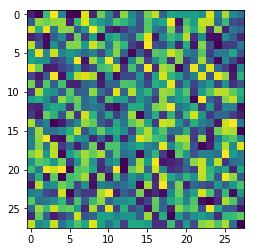

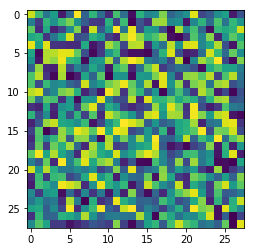

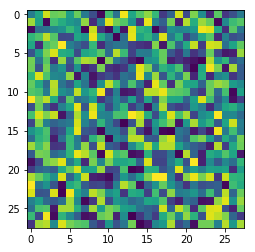

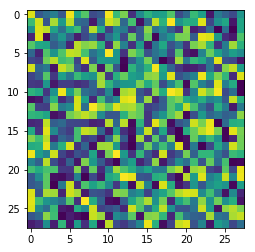

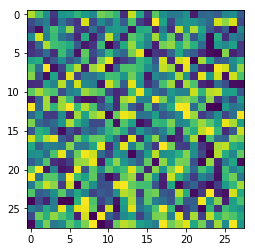

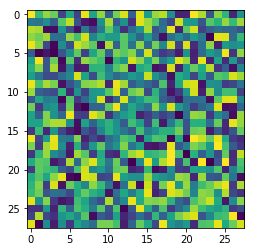

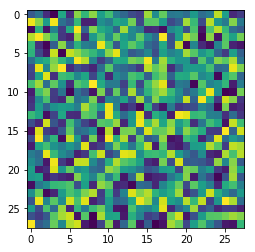

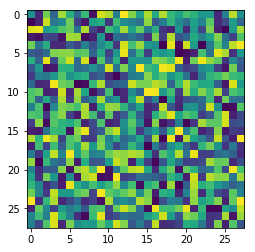

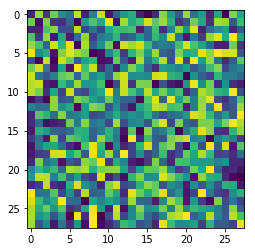

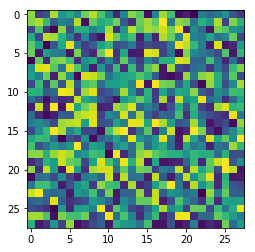

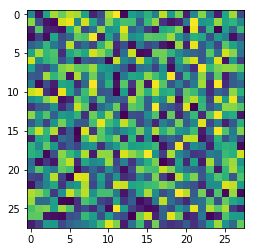

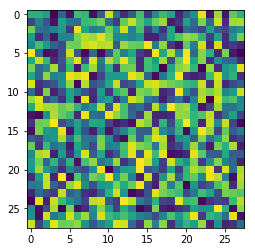

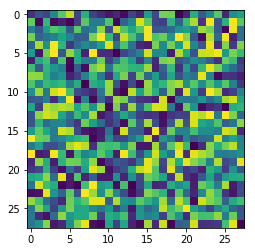

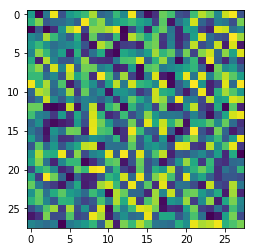

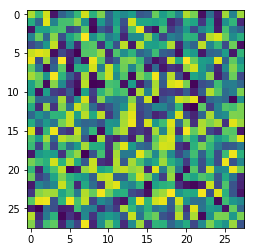

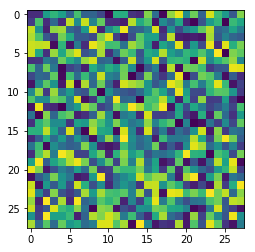

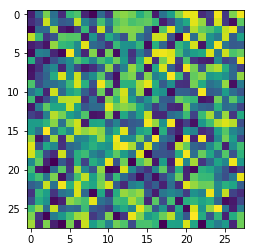

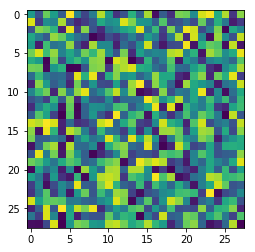

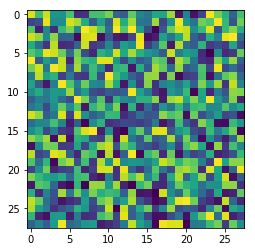

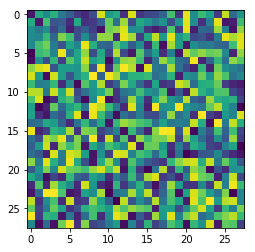

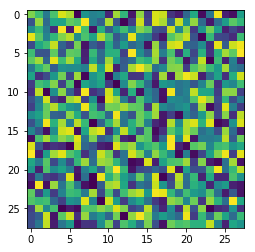

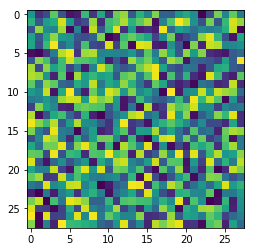

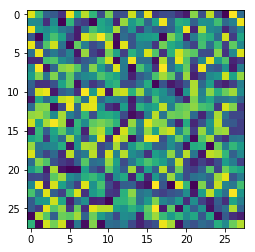

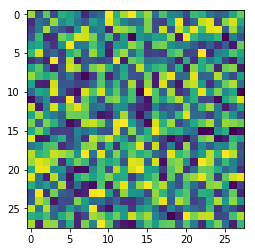

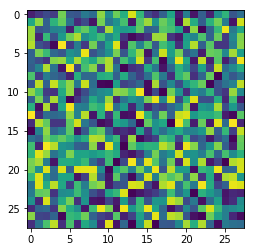

In [22]:
first_layer = all_W[0][:,1:]
print(first_layer.shape)
i = 0
for row in first_layer:
    img = np.reshape(row,(28,28))
    plt.imshow(img)
    plt.show()

In [23]:
training(all_W, train_input, train_truth, batch_size=30, num_loop=3, learning_rate=0.1)

Iterate  1  loss:  1.9882979559385832
Iterate  2  loss:  0.7406716071118571
Iterate  3  loss:  0.41385393927124514


(25, 784)


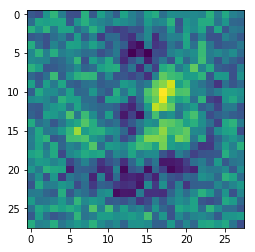

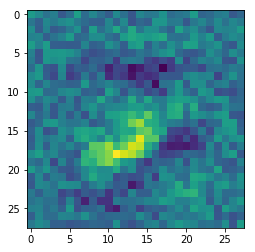

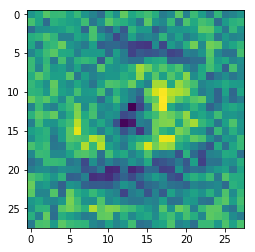

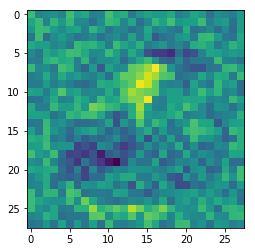

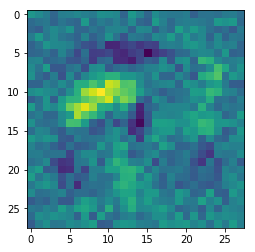

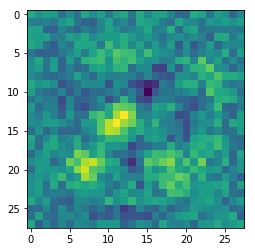

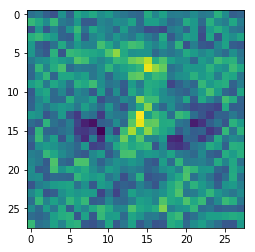

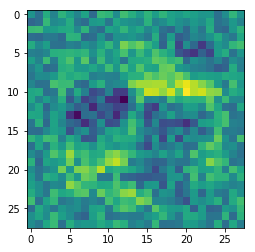

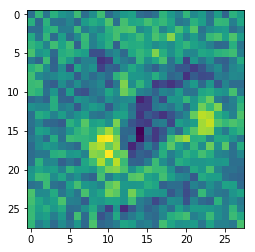

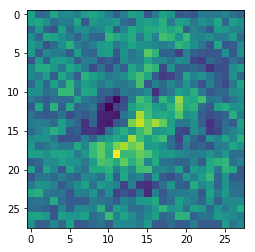

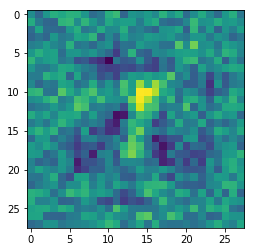

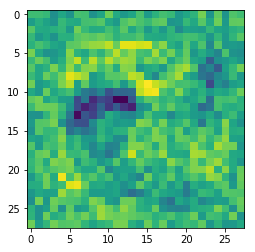

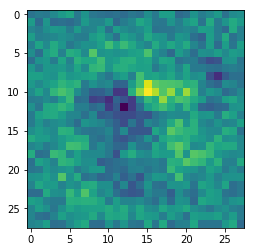

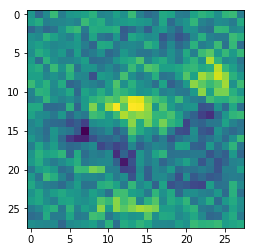

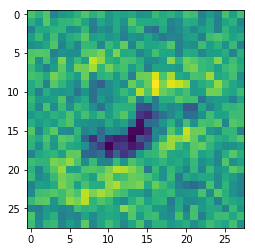

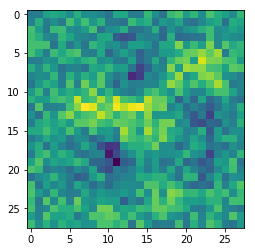

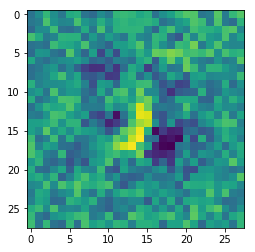

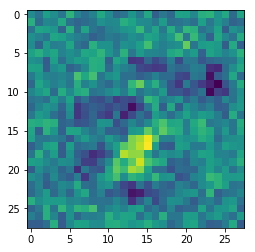

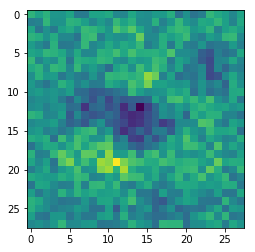

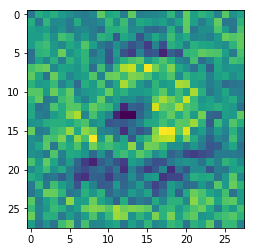

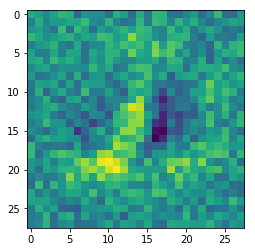

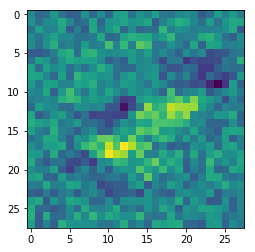

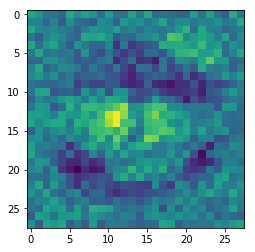

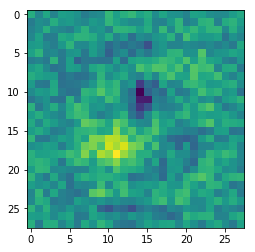

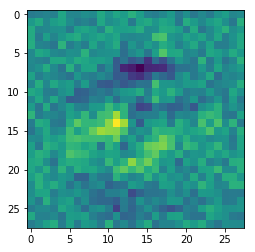

In [24]:
first_layer = all_W[0][:,1:]
print(first_layer.shape)
i = 0
for row in first_layer:
    img = np.reshape(row,(28,28))
    plt.imshow(img)
    plt.show()

In [25]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [26]:
test_img_input = (test_img/255).T
test_label_truth = test_label.T

list_grad, list_activation, cost = neural_network(all_W, test_img_input, test_label_truth)
pred = list_activation[len(all_W)].argmax(0)
answer = test_label_truth.argmax(0)
compare_vector = (pred == answer)
num_correct = np.sum(compare_vector)
m = len(compare_vector)
print("Accuracy: ", num_correct / m * 100,"%")
print("Cost: ", cost)
print()
print("Confusion matrix: ")
y_actu = pd.Series(answer, name='Actual')
y_pred = pd.Series(pred, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)
print()
print("Normalized confusion matrix: ")
df_conf_norm = round(df_confusion / df_confusion.sum(axis=1) * 100, 1)
print(df_conf_norm)

Accuracy:  89.9 %
Cost:  0.3516831933285374

Confusion matrix: 
Predicted    0     1    2    3    4    5    6    7    8    9
Actual                                                      
0          943     0    1    1    1   17   15    1    1    0
1            0  1105    1    5    0    0    1    1   20    2
2           17    10  913   17   14    2   16    9   29    5
3            3     2   25  877    0   53    1   17   25    7
4            0     2    3    0  896    0   23    1    4   53
5           15     2    8   45    7  743   18    4   38   12
6           32     3    4    0   22   12  880    0    5    0
7            2    30   20    3    4    1    0  891    1   76
8            3    16    3   16   11   47   14    2  843   19
9            3     9    2    5   49   20    3   16    3  899

Normalized confusion matrix: 
Predicted     0     1     2     3     4     5     6     7     8     9
Actual                                                               
0          96.2   0.0   0.1   0.1